## test Feature_Branch

In [6]:
from modules.FeatureBranch import Feature_Branch

reshape_channel = 32
reshape_depth = 16
num_resblocks = 6
linear_channels = [3072, 2048, 1024, 768]
upsample_channels = [3072, 2048, 1024, 512]
downsample_channels = [512, 512, 512, 768]
arcface_path = '/home/wenchi/zxy/HSD/utils/arcface_pytorch/checkpoints/resnet18_110_onecard.pth' 
resNext_path = '/home/wenchi/zxy/HSD/utils/ResNeXt/resnext_50_32x4d_modified.pth'

test_branch = Feature_Branch(   
                reshape_channel= reshape_channel, 
                 reshape_depth = reshape_depth, 
                 num_resblocks = num_resblocks, 
                 upsample_channels = upsample_channels, 
                 downsample_channels = downsample_channels, 
                 arcface_path = arcface_path, 
                 resNext_path = resNext_path,
                 linear_channels = linear_channels)


In [7]:
import torch
test_branch.cuda()

data_for_id = torch.randn(4, 1024).cuda()
data_for_global = torch.randn(4, 3, 224, 224).cuda()

In [8]:
import pickle
with open('/data0/wc_data/VFHQ/test/Clip+_HebIzK_LP4+P2+C1+F16589-16715/3DMM_feature.pkl', 'rb') as f:
    data = pickle.load(f)
verts = data['trans_verts'] # (N, 5023, 3)
mesh_target = verts[:4].cuda() # (4, 5023, 3)
mesh_source = verts[4:8].cuda()

In [9]:
out = test_branch(data_for_id, data_for_global, mesh_source, mesh_target)

## test Condition_Branch

In [1]:
from modules.ConditionBranch import Condition_Branch

test_branch = Condition_Branch()

/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


creating the FLAME Decoder
trained model found. load /home/wenchi/zxy/HSD/utils/DECA/data/deca_model.tar


/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: Mtl file does not exist: /home/wenchi/zxy/HSD/utils/DECA/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [2]:
import random
import torch
def get_code_dict(code_dict, batch_size = 4, pose_threshold = 0.02):
    # this method get original a clip code_dict as input
    # return the indexs selected randomly and the corresponding combined code_dict

    tforms = code_dict['tforms']
    shape_code = code_dict['shape']
    tex_code = code_dict['tex']
    exp_code = code_dict['exp']
    pose_code = code_dict['pose']
    cam_code = code_dict['cam']
    light_code = code_dict['light']

    tforms_new = torch.zeros(batch_size, tforms.shape[1], tforms.shape[2])
    shape_code_new = torch.zeros(batch_size, shape_code.shape[1])
    tex_code_new = torch.zeros(batch_size, tex_code.shape[1])
    exp_code_new = torch.zeros(batch_size, exp_code.shape[1])
    pose_code_new = torch.zeros(batch_size, pose_code.shape[1])
    cam_code_new = torch.zeros(batch_size, cam_code.shape[1])
    light_code_new = torch.zeros(batch_size, light_code.shape[1], light_code.shape[2])

    total_num = pose_code.shape[0]
    count = 0
    index = []

    while True:
        a = random.randint(0, total_num-1)       # a for source
        b = random.randint(0, total_num-1)       # b for target
        if abs(torch.mean(pose_code[a] - pose_code[b])) >= pose_threshold:

            # get combined code
            tforms_new[count, :] = tforms[b]
            shape_code_new[count, :] = shape_code[a]
            tex_code_new[count, :] = tex_code[a]
            exp_code_new[count, :] = exp_code[b]
            pose_code_new[count, :] = pose_code[b]
            cam_code_new[count, :] = cam_code[b]
            light_code_new[count, :] = light_code[b]

            # get index
            index.append((a, b))

            count +=1

            if count == batch_size:
                new_code_dict = {
                    'tforms':tforms_new.cuda(),
                    'shape':shape_code_new.cuda(),
                    'tex':tex_code_new.cuda(),
                    'exp':exp_code_new.cuda(),
                    'pose':pose_code_new.cuda(),
                    'cam':cam_code_new.cuda(),
                    'light':light_code_new.cuda()
                }
                return new_code_dict, index
        else:
            continue

In [22]:
import pickle
import os.path as osp
import numpy as np
from PIL import Image
import cv2
import torch

clip_path = '/data0/wc_data/VFHQ/train/Clip+xz26EN_LRa8+P0+C0+F4517-4639'

with open(osp.join(clip_path, '3DMM_condition.pkl'), 'rb') as f:
    data = pickle.load(f)

codedict, index = get_code_dict(data)

source_image_list = []
target_image_list = []
mask_image_list = []
bg_image_list = []


# get images
for i in range(len(index)):
    source_image_path = osp.join(clip_path, '{}.png'.format(str(index[i][0]).zfill(8)))
    target_image_path = osp.join(clip_path, '{}.png'.format(str(index[i][1]).zfill(8)))
    mask_image_path = osp.join(clip_path, 'mask_{}.jpg'.format(str(index[i][1]).zfill(8)))
    source_image_list.append(np.asarray(Image.open(source_image_path).convert("RGB")))
    target_image_list.append(np.asarray(Image.open(target_image_path).convert("RGB")))
    mask_image_list.append(np.asarray(Image.open(mask_image_path)))

# get masked images (background)
for i in range(len(index)):
    mask = mask_image_list[i]
    mask = cv2.GaussianBlur(mask, (11, 11), 11)
    mask = np.where( (mask <= 0), 0, 255).astype('uint8')
    bg_image_list.append(cv2.bitwise_and(target_image_list[i], target_image_list[i], mask = 255 - mask))

source_images = np.asarray(source_image_list)
target_images = np.asarray(target_image_list) # np.array, uint8, 
mask_images = np.asarray(mask_image_list)
bg_images = np.asarray(bg_image_list)

bg_images = torch.from_numpy((bg_images / 255.0).transpose(0, 3, 1, 2))
bg_images = bg_images.cuda()

# for key in codedict:
#     print('key: {} has shape : {} '.format(key, str(codedict[key].shape)))

out = test_branch(codedict, bg_images)

Image_source = source_image_list[0]
Image_target = target_image_list[0]
Image_mask = np.tile(mask_image_list[0] , (3, 1, 1)).transpose(1, 2, 0)
Image_bg = bg_image_list[0]
Image_out = (out[0].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

Image_concat = np.concatenate((Image_source, Image_target, Image_mask, Image_bg, Image_out), axis= 1)
a = Image.fromarray(Image_concat)
a.save('/home/wenchi/zxy/HSD/test_condition.jpg')



In [ ]:
### test pose distance and test for pose threshold

In [20]:
import pickle
import matplotlib.pyplot as plt
import random

with open('/data0/wc_data/VFHQ/train/Clip+_aZphIp0KQE+P0+C1+F2675-2891/3DMM_condition.pkl', 'rb') as f:
    data = pickle.load(f)

pose_code = data['pose']

total_num = pose_code.shape[0]
 
plt.figure(figsize=(10, 10))

row_list = []
col_list = []
# for i in range(1, 100):
#     sum = 0
#     for j in range(total_num - i):
#         pose_1 = pose_code[j]
#         pose_2 = pose_code[j+i]
#         sum += torch.mean(pose_1 - pose_2)
#     sum /= (total_num - i)
#     print('间隔{}帧的图像pose 平均差值为{}'.format(i, sum))
#     i_list.append(i)
#     sum_list.append(sum)
result = [0, 0, 0, 0, 0, 0, 0]
for i in range(100000):
    a = random.randint(0, total_num-1)
    b = random.randint(0, total_num-1)

    pose_1 = pose_code[a]
    pose_2 = pose_code[b]
    temp = torch.mean(pose_1 - pose_2)
    index = min(abs(int(temp / 0.01)), 6)
    result[index] +=1


plt.scatter(['0~0.01', '0.01~0.02', '0.02~0.03', '0.03~0.04', '0.04~0.05', '0.05~0.06', '>=0.06'], result)
plt.show()

In [6]:
import torch
a = torch.randn(6)
b = torch.randn(6)
print(a-b)
print(torch.mean(a - b))

tensor([-0.3337, -1.2104, -0.6803, -1.8381,  0.2894,  2.4729])
tensor(-0.2167)


## test combine ckpt

In [2]:
import sys
import os

os.system('export PYTHONPATH=/home/wenchi/zxy/HSD/ControlNet/')
sys.path.append('/home/wenchi/zxy/HSD/ControlNet/')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
input_path = "/data1/wc_log/zxy/ckpt/v3-epoch=04-global_step=4849.0.ckpt"
output_path = "/data1/wc_log/zxy/control_pbe_CLIP_ini_1.ckpt"

assert os.path.exists(input_path), 'Input model does not exist.'
assert not os.path.exists(output_path), 'Output filename already exists.'
assert os.path.exists(os.path.dirname(output_path)), 'Output path is not valid.'

import torch
from share import *
from cldm.model import create_model


def get_node_name(name, parent_name):
    if len(name) <= len(parent_name):
        return False, ''
    p = name[:len(parent_name)]
    if p != parent_name:
        return False, ''
    return True, name[len(parent_name):]

logging improved.


In [4]:
# from modules.FeatureBranch import Feature_Branch

# reshape_channel = 32
# reshape_depth = 16
# num_resblocks = 6
# linear_channels = [3072, 2048, 1024, 768]
# upsample_channels = [3072, 2048, 1024, 512]
# downsample_channels = [512, 512, 512, 768]
# arcface_path = '/home/wenchi/zxy/HSD/utils/arcface_pytorch/checkpoints/resnet18_110_onecard.pth' 
# resNext_path = '/home/wenchi/zxy/HSD/utils/ResNeXt/resnext_50_32x4d_modified.pth'

# test_branch = Feature_Branch(   
#                 reshape_channel= reshape_channel, 
#                  reshape_depth = reshape_depth, 
#                  num_resblocks = num_resblocks, 
#                  upsample_channels = upsample_channels, 
#                  downsample_channels = downsample_channels, 
#                  arcface_path = arcface_path, 
#                  resNext_path = resNext_path,
#                  linear_channels = linear_channels)

# condition_weight = test_branch.state_dict()
pretrained_weights = torch.load(input_path)['state_dict']


In [5]:
contrast_weights = torch.load('/data1/wc_log/zxy/ckpt/v3.1-epoch=00-global_step=969.0.ckpt')['state_dict']

In [9]:
a = pretrained_weights['cond_stage_model.mapper.resblocks.0.attn.c_qkv.weight']
b = contrast_weights['cond_stage_model.mapper.resblocks.0.attn.c_qkv.weight']
distance = a - b
print(distance.data)

tensor([[-1.3193e-05,  3.0932e-04, -7.5172e-05,  ..., -2.1119e-04,
          6.3138e-05, -7.7147e-05],
        [ 9.3297e-05, -3.2656e-04, -1.5115e-04,  ..., -6.6311e-05,
          2.1505e-04,  2.5551e-04],
        [-1.0073e-04, -1.5519e-04, -1.8450e-05,  ...,  2.6213e-04,
          1.2745e-04,  2.5876e-04],
        ...,
        [-5.6947e-05,  1.3173e-04,  2.9555e-04,  ...,  1.7552e-04,
          1.4542e-04,  2.0300e-04],
        [ 3.4345e-04,  1.6546e-04,  4.5956e-04,  ...,  3.9213e-04,
          1.9134e-04, -2.1023e-04],
        [-8.0807e-05, -9.6441e-05, -1.2407e-04,  ..., -5.1800e-05,
         -3.1838e-04, -1.8885e-04]], device='cuda:0')


In [8]:
print(torch.min(distance))

tensor(0., device='cuda:0')


In [43]:
pretrained_weights_keys = list(pretrained_weights.keys())
for key in pretrained_weights_keys:
    print(key)
    # prefix = key.split('.', 1)[0]
    # if prefix == 'cond_stage_model':
    #     del pretrained_weights[key]

# for key in condition_weight:
#     add_key = 'cond_stage_model.' + key
#     pretrained_weights[add_key] = condition_weight[key].clone()

betas
alphas_cumprod
alphas_cumprod_prev
sqrt_alphas_cumprod
sqrt_one_minus_alphas_cumprod
log_one_minus_alphas_cumprod
sqrt_recip_alphas_cumprod
sqrt_recipm1_alphas_cumprod
posterior_variance
posterior_log_variance_clipped
posterior_mean_coef1
posterior_mean_coef2
logvar
model.diffusion_model.time_embed.0.weight
model.diffusion_model.time_embed.0.bias
model.diffusion_model.time_embed.2.weight
model.diffusion_model.time_embed.2.bias
model.diffusion_model.input_blocks.0.0.weight
model.diffusion_model.input_blocks.0.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.0.weight
model.diffusion_model.input_blocks.1.0.in_layers.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.2.weight
model.diffusion_model.input_blocks.1.0.in_layers.2.bias
model.diffusion_model.input_blocks.1.0.emb_layers.1.weight
model.diffusion_model.input_blocks.1.0.emb_layers.1.bias
model.diffusion_model.input_blocks.1.0.out_layers.0.weight
model.diffusion_model.input_blocks.1.0.out_layers.0.bias
model.diffusi

In [3]:
model = create_model(config_path='/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v2.yaml')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)
# print(model.state_dict().keys())

No module 'xformers'. Proceeding without it.
ControlLDM_HSD: Running in eps-prediction mode
DiffusionWrapper has 859.54 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.10.mlp.fc1.bias', 'text_model.encoder.layers.5.self_attn.k_proj.weight', 'text_model.encoder.layers.2.mlp.fc2.weight', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.3.layer_norm1.weight', 'text_model.encoder.layers.6.mlp.fc2.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.5.self_attn.v_proj.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.

Loaded model config from [/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v2.yaml]
model.diffusion_model.time_embed.0.weight
model.diffusion_model.time_embed.0.bias
model.diffusion_model.time_embed.2.weight
model.diffusion_model.time_embed.2.bias
model.diffusion_model.input_blocks.0.0.weight
model.diffusion_model.input_blocks.0.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.0.weight
model.diffusion_model.input_blocks.1.0.in_layers.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.2.weight
model.diffusion_model.input_blocks.1.0.in_layers.2.bias
model.diffusion_model.input_blocks.1.0.emb_layers.1.weight
model.diffusion_model.input_blocks.1.0.emb_layers.1.bias
model.diffusion_model.input_blocks.1.0.out_layers.0.weight
model.diffusion_model.input_blocks.1.0.out_layers.0.bias
model.diffusion_model.input_blocks.1.0.out_layers.3.weight
model.diffusion_model.input_blocks.1.0.out_layers.3.bias
model.diffusion_model.input_blocks.1.1.norm.weight
model.diffusion_model.input_blocks.1

In [6]:
scratch_dict = model.state_dict()

target_dict = {}
for k in scratch_dict.keys():
    is_control, name = get_node_name(k, 'control_')
    if is_control:
        copy_k = 'model.diffusion_' + name
    else:
        copy_k = k
    if copy_k in pretrained_weights:
        target_dict[k] = pretrained_weights[copy_k].clone()
    else:
        target_dict[k] = scratch_dict[k].clone()
        print(f'These weights are newly added: {k}')

model.load_state_dict(target_dict, strict=True)
torch.save(model.state_dict(), output_path)
print('Done.')

These weights are newly added: logvar
These weights are newly added: control_model.zero_convs.0.0.weight
These weights are newly added: control_model.zero_convs.0.0.bias
These weights are newly added: control_model.zero_convs.1.0.weight
These weights are newly added: control_model.zero_convs.1.0.bias
These weights are newly added: control_model.zero_convs.2.0.weight
These weights are newly added: control_model.zero_convs.2.0.bias
These weights are newly added: control_model.zero_convs.3.0.weight
These weights are newly added: control_model.zero_convs.3.0.bias
These weights are newly added: control_model.zero_convs.4.0.weight
These weights are newly added: control_model.zero_convs.4.0.bias
These weights are newly added: control_model.zero_convs.5.0.weight
These weights are newly added: control_model.zero_convs.5.0.bias
These weights are newly added: control_model.zero_convs.6.0.weight
These weights are newly added: control_model.zero_convs.6.0.bias
These weights are newly added: control

## test CLIP

In [1]:
from transformers import  CLIPVisionModel
from ControlNet.ldm.modules.encoders.xf import LayerNorm, Transformer

version="openai/clip-vit-large-patch14"
transformer = CLIPVisionModel.from_pretrained(version)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.4.layer_norm2.weight', 'text_model.encoder.layers.8.mlp.fc2.weight', 'text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.2.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.10.self_attn.v_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.8.self_attn.out_proj.bias', 'text_model.encoder.layers.3.self_attn.out_proj.bias

In [38]:
import torch
image = torch.rand(2, 3, 224, 224)

mapper = Transformer(
                n_ctx = 257,
                width = 1024,
                layers = 5,
                heads = 8,
            )
final_ln = LayerNorm(1024)

In [39]:
with torch.no_grad():
    outputs = transformer(pixel_values=image)
    print('last_hidden_state : ', outputs.last_hidden_state.shape)
    print('pooler_output : ', outputs.pooler_output.shape)

    z = outputs.last_hidden_state
    print('z : ', z.shape)
    z = mapper(z)
    print('z mapper: ', z.shape)
    z = final_ln(z)
    print('z final: ', z.shape)

last_hidden_state :  torch.Size([2, 257, 1024])
pooler_output :  torch.Size([2, 1024])
z :  torch.Size([2, 257, 1024])
z mapper:  torch.Size([2, 257, 1024])
z final:  torch.Size([2, 257, 1024])


## test mask process

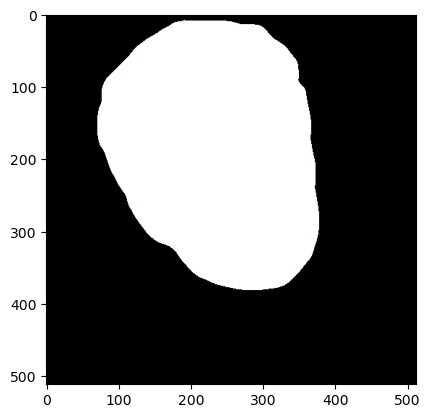

In [61]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def mask_find_bbox(mask):
    mask_col = np.sum(mask, axis= 0)
    mask_row = np.sum(mask, axis= 1)

    left = np.where(mask_col >= 255)[0][0]
    right = np.where(mask_col >= 255)[0][-1]
    up = np.where(mask_row >= 255)[0][0]
    down = np.where(mask_row >= 255)[0][-1]

    bbox = [left, up, right, down]
    return bbox

def smooth_mask(mask_image):
    mask_image = cv2.GaussianBlur(mask_image, (11, 11), 11)
    mask_image = np.where( (mask_image <= 0), 0, 255).astype('uint8')
    return mask_image

def get_align_image(bbox, img, reshape_size = 224):
    h, w, _ = img.shape
    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]

    center_point = [int((x1 + x2) / 2), int((y1 + y2) / 2)] ## recalculate the center point
    expand_size = int((y2 - y1) * 0.5) # expand_size -- half of the total crop size
    crop_size = expand_size * 2

    new_x1 = center_point[0] - expand_size
    new_x2 = center_point[0] + expand_size
    new_y1 = center_point[1] - expand_size
    new_y2 = center_point[1] + expand_size

    (crop_left, origin_left) = (0, new_x1) if new_x1 >= 0 else (-new_x1, 0)
    (crop_right, origin_right) = (crop_size, new_x2) if new_x2 <= w else (w-new_x1, w)
    (crop_top, origin_top) = (0, new_y1) if new_y1 >= 0 else (-new_y1, 0)
    (crop_bottom, origin_bottom) = (crop_size, new_y2) if new_y2 <= h else (h-new_y1, h)

    aligned_img = np.zeros((crop_size, crop_size, 3), dtype=np.uint8)
    aligned_img[crop_top:crop_bottom, crop_left:crop_right] = img[origin_top:origin_bottom, origin_left:origin_right]
    aligned_img = Image.fromarray(aligned_img)
    aligned_img = aligned_img.resize((reshape_size, reshape_size))
    aligned_img = np.asarray(aligned_img)
    return aligned_img

source_mask_path = '/data0/wc_data/VFHQ/train/Clip+Y8k-XLGO2SY+P0+C0+F950-1055/mask_00000067.jpg'
source_mask = np.asarray(Image.open(source_mask_path)) # (H, W)
source_mask = smooth_mask(source_mask)

plt.imshow(source_mask, cmap='bone')

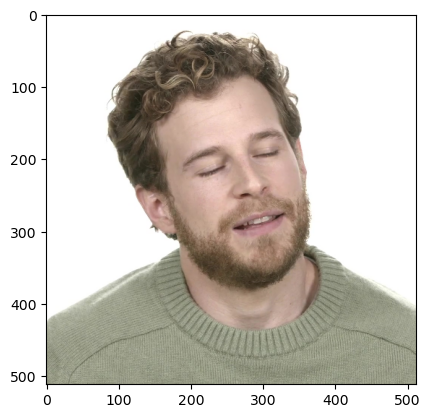

In [62]:
source_image_path = '/data0/wc_data/VFHQ/train/Clip+Y8k-XLGO2SY+P0+C0+F950-1055/00000067.png'
source_image = np.asarray(Image.open(source_image_path).convert("RGB"))
plt.imshow(source_image)

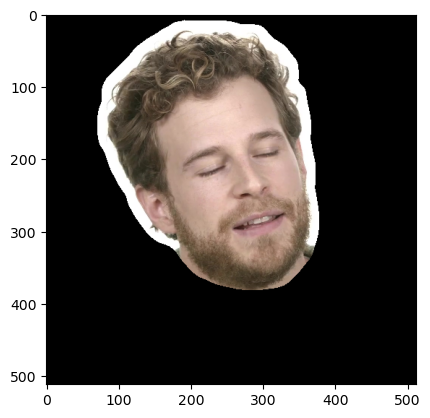

In [63]:
source_image = cv2.bitwise_and(source_image, source_image, mask = source_mask)
plt.imshow(source_image)

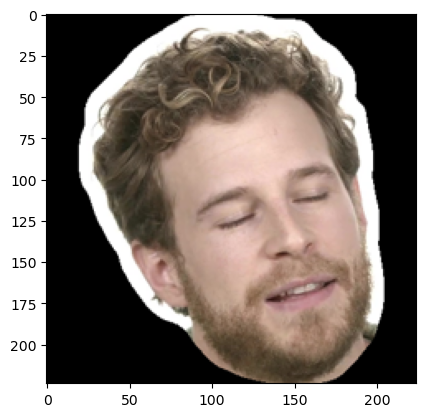

In [64]:
bbox = mask_find_bbox(source_mask)
source_image = get_align_image(bbox=bbox, img=source_image)
plt.imshow(source_image)

## test random mask

In [4]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def smooth_mask(mask_image, ksize=(11, 11), sigmaX= 11, sigmaY= 11):
    # need to be applied in data preprocess, and drop this
    # GaussianBlur again to reduce mask edge serrate
    mask_image = cv2.GaussianBlur(mask_image, ksize, sigmaX=sigmaX, sigmaY = sigmaY)
    mask_image = np.where( (mask_image <= 0), 0, 255).astype('uint8')
    return mask_image

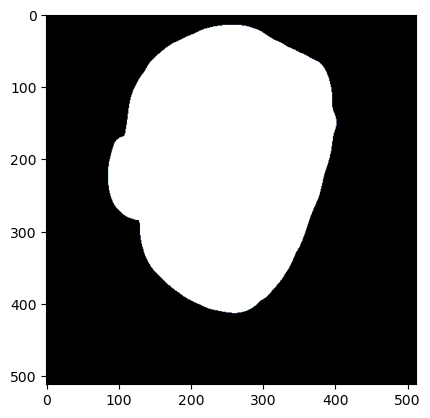

In [62]:
target_image_path = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000021.png'
# target_mask_path = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/mask_00000021.jpg'
target_mask_path = '/data0/wc_data/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/mask_00000053.jpg'

target_image = np.asarray(Image.open(target_image_path).convert("RGB"))
target_mask_image = np.asarray(Image.open(target_mask_path))

plt.imshow(target_mask_image, cmap= 'bone')

[11, 23, 17, 15]


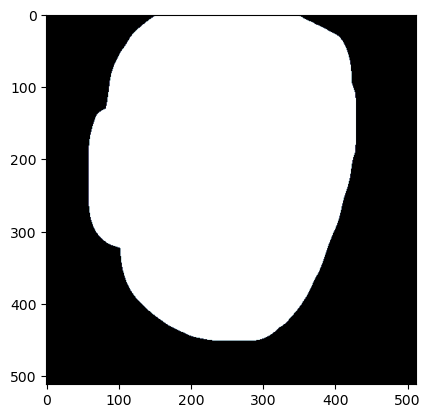

In [69]:
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(55, 55), sigmaX= 33, sigmaY= 33)
import random
random_int = random.sample(range(-10, 30), 4)
print(random_int)
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(33, 33), sigmaX= 33, sigmaY= 33)
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(11, 11), sigmaX= 33, sigmaY= 33)
target_mask_image_big = smooth_mask(target_mask_image,ksize=(33 + random_int[0]*2, 33 + random_int[1]*2), sigmaX= 33 + random_int[2]*2, sigmaY= 43 + random_int[3]*2)
plt.imshow(target_mask_image_big, cmap= 'bone')

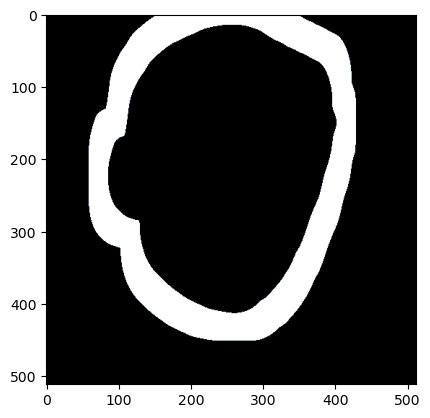

In [70]:
target_mask_image_distance = target_mask_image_big - target_mask_image
plt.imshow(target_mask_image_distance, cmap= 'bone')

## test

In [1]:
import pickle
with open('/data0/wc_data/VFHQ/train/Clip+Y8k-XLGO2SY+P0+C0+F950-1055/3DMM_condition.pkl', 'rb') as f:
    dict = pickle.load(f)

tforms = dict['tforms']

In [72]:
import numpy as np
import torchvision
import torch
from PIL import Image

a = torch.from_numpy(np.zeros((2, 3, 512, 512)))
b = np.ones((2, 3, 512, 512))

grid = torchvision.utils.make_grid(a, nrow=1)
grid = np.asarray(Image.f)
# grid_list = []
# grid_list.append(a)
# grid_list.append(b)
# grid_list.append(c)

# d = np.concatenate(grid_list, axis=0)